In [2]:
#!/usr/bin/env python
# coding: utf-8

from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd

##########################################################################################
''' Marker list '''
marker_list = ['d', 'o', 'x', 'v', '^', '<', '>', 's', '8', 'p']

''' Linewidth '''
lw = 5

''' Color list '''
## Manually set color list
# color_list = ["blue", "orange", "green", "purple", "brown", "#FBDD7E", "cyan", "#C20078", "#FAC205", "gray",  "#06C2AC", "#FFFF14", "#E6DAA6","olive", "#76FF7B", "pink", "#BC8F6", "#AAA662"]
## Tableau color list
color_dict = mcolors.TABLEAU_COLORS
color_list = list()
for name in color_dict:
    color_list.append(color_dict[name])

''' Line style '''
line_style_list = ["solid", "dashdot", "dashed", 'dotted']
##########################################################################################

# routing_algorithm = ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE"]
routing_algorithm = ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE", "RoundRobin-capacity_TE"]
# routing_algorithm = ["RoundRobin-MCLB", "RoundRobin-heuristic_TE"]
cluster_id = [0, 1]


In [85]:


def plot_latency_cdf(latency_dict_):
    fig = plt.figure()
    color_idx = 0
    ls_idx = 0
    for key in latency_dict_:
        x_0 = np.sort(latency_dict_[key])
        num_data_point_0 = len(latency_dict_[key])
        y_0 = np.arange(num_data_point_0) / float(num_data_point_0)
        plt.plot(x_0, y_0, label=key, color=color_list[color_idx], linewidth=lw, linestyle=line_style_list[ls_idx])
        color_idx += 1
        ls_idx += 1
    # plt.title("cluster", fontsize=30)
    plt.xlim(0, )
    plt.xlabel('Request latency(ms)', fontsize=30)
    plt.ylabel('CDF', fontsize=25)
    # plt.legend(loc="lower right", fontsize=14, frameon = False)
    plt.legend(loc="lower right", fontsize=16)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    # plt.savefig(path+workload+"-"+cluster_name+"-latency_cdf.pdf", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    

def find_tail_idx(data, tail=0.95):
    tail_idx = 0
    for i in range(len(data)):
        if data[i] >= tail:
            tail_idx = i
            break
    print("{}, tail_idx: {}".format("???", tail_idx))
    return tail_idx
    
def plot_tail_latency_cdf(latency_dict_):
    fig = plt.figure()     
    color_idx = 0
    ls_idx = 0
    for key in latency_dict_:
        num_data_point_0 = len(latency_dict_[key])
        y_0 = np.arange(num_data_point_0) / float(num_data_point_0)
        tail = 0.95
        tail_idx = find_tail_idx(y_0, tail)
        y_tail = y_0[tail_idx:]
        x_0 = np.sort(latency_dict_[key])
        x_tail = x_0[tail_idx:]
        plt.plot(x_tail, y_tail, label=key, color=color_list[color_idx], linewidth=lw, linestyle=line_style_list[ls_idx])
        color_idx += 1
        ls_idx += 1
    # plt.title("Bursty cluster", fontsize=30)
    plt.xlim(0, )
    plt.xlabel('Request latency(ms)', fontsize=30)
    plt.ylabel('CDF', fontsize=25)
    # plt.legend(loc="lower right", fontsize=14, frameon = False)
    plt.legend(loc="lower right", fontsize=16)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    # plt.savefig(path+workload+"-"+cluster_name+"-tail_latency_cdf.pdf", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    
def parse_latency_file(f_):
    data = f_.readlines()
    latency = list()
    for elem in data:
        latency.append(float(elem.strip()))
    return latency

def latency_file_to_df(f_):
    df = pd.read_csv(f_, header=None)
    df.columns=["request_latency"]
    df = df.sort_values(by=["request_latency"])
    df = df.reset_index(drop="True")
    return df


def print_statistics(latency_dict_):
    for key in latency_dict_:
        print("="*30)
        print(key)
        print("- Avg: {}".format(round(np.mean(latency_dict_[key]), 2)))
        print("- 50p: {}".format(round(np.percentile(latency_dict_[key], 50), 2)))
        print("- 90p: {}".format(round(np.percentile(latency_dict_[key], 90), 2)))
        print("- 95p: {}".format(round(np.percentile(latency_dict_[key], 95), 2)))
        print("- 99p: {}".format(round(np.percentile(latency_dict_[key], 99), 2)))
        print("- 99.9p: {}".format(round(np.percentile(latency_dict_[key], 99.9), 2)))

def plot_quantile(ser):
    q_list = [0.5, 0.9, 0.95, 0.99, 0.999]
    # q_list = [0.5, 0.9, 0.95, 0.99]
    quantiles = list()
    for q in q_list:
        temp = int(ser.quantile(q))
        quantiles.append(temp)
        print("{}: {}".format(str(q), temp))
    return quantiles

def parse_metadata(path):
    f_ = open(path, 'r')
    lines = f_.readlines()
    application = lines[0].split(":")[-1].strip()
    load_balancer = lines[1].split(":")[-1].strip()
    routing = lines[2].split(":")[-1].strip()
    return application, load_balancer, routing

def plot_latency(common_path, ra_ = list()):
    c0_files = list()
    c1_files = list()
    metadata_files = list()
    if len(ra_) > 0:
        ra = ra_
    else:
        ra = routing_algorithm
    for routing in ra:
        metad = common_path + routing + "/metadata.txt"
        c0_f_ = common_path + routing + "/latency-cluster_0.txt"
        c1_f_ = common_path + routing + "/latency-cluster_1.txt"
        c0_files.append(c0_f_)
        c1_files.append(c1_f_)
        # metadata_files.append(metad)
        try:
            assert c0_f_.split(".")[-1] == "txt" and c0_f_.split("/")[-1].split("-")[0] == "latency"
            assert c1_f_.split(".")[-1] == "txt" and c1_f_.split("/")[-1].split("-")[0] == "latency"
        except:
            print("invalid file name: {}".format(c0_f_))
            print("invalid file name: {}".format(c1_f_))
            exit()

    latency_files = [c0_files, c1_files]
    qt_list = list()
    cdf_list = list()
    df_dict = dict()
    for cid in cluster_id:
        for i in range(len(ra)):
            file_ = open(latency_files[cid][i], 'r')
            df = latency_file_to_df(file_)
            df_dict[ra[i]+str(cid)] = df # L0, M0, T0, L1, M1, T1
            # print("{}, {}".format("Cluster"+str(cid), ra[i]))
            # qt_list.append(plot_quantile(df["request_latency"]))
            cdf = df['request_latency'].value_counts().sort_index().cumsum() / len(df)
            cdf_list.append(cdf) # L0, M0, T0, L1, M1, T1
    
    
    fig = plt.figure(figsize=(10, 3.5))
    subplot_pos = 1
    ax1 = fig.add_subplot(1,3, subplot_pos) # (row, col, the position of the current plot)
    ## Overall performance
    xmin = list()
    xmax = list()
    q_ = [0.95, 1.0]
    for r_ in ra:
        temp = list()
        for cid in cluster_id:
            temp.append(df_dict[r_+str(cid)])
        merged_df = pd.concat(temp, ignore_index=True)
        cdf = merged_df['request_latency'].value_counts().sort_index().cumsum() / len(merged_df)
        cdf.plot(kind='line', label=r_)
        xmin.append(np.percentile(cdf.index, q_[0]*100))
        xmax.append(np.percentile(cdf.index, q_[1]*100))
    # plt.xlim(min(xmin)-100, min(xmax)+100)
    # plt.ylim(q_[0], q_[1]+0.001)
    # plt.tick_params(axis='y', labelsize=10)
    # plt.tick_params(axis='x', labelsize=10)
    # plt.xlabel('Request latency(ms)', fontsize=10)
    # plt.ylabel('CDF', fontsize=10)
    # plt.legend(loc="lower right", fontsize=10)
    # plt.title("Overall perf", fontsize=10)
    
    # ax1.set_xlim(min(xmin)-100, min(xmax)+100)
    if max(xmax) > 500:
        ax1.set_xlim(0, 500)
    else:
        ax1.set_xlim(0, max(xmax))
    ax1.set_ylim(q_[0], q_[1])
    ax1.tick_params(axis='y', labelsize=10)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.set_xlabel('Request latency(ms)', fontsize=10)
    ax1.set_ylabel('CDF', fontsize=10)
    # ax1.legend(loc="lower right", fontsize=10)
    ax1.set_title("Overall perf", fontsize=10)
    subplot_pos += 1
    
    idx=0
    for cid in cluster_id:
        xmin = list()
        xmax = list()
        ax1 = fig.add_subplot(1,3, subplot_pos) # (row, col, the position of the current plot)
        for routing in ra:
            cdf_list[idx].plot(kind='line', label=routing)
            xmin.append(np.percentile(cdf_list[idx].index, q_[0]*100))
            xmax.append(np.percentile(cdf_list[idx].index, q_[1]*100))
            idx+=1
        if max(xmax) > 500:
            ax1.set_xlim(0, 500)
        else:
            ax1.set_xlim(0, max(xmax))
        ax1.set_ylim(q_[0], q_[1])
        ax1.tick_params(axis='y', labelsize=10)
        ax1.tick_params(axis='x', labelsize=10)
        ax1.set_xlabel('Request latency(ms)', fontsize=10)
        ax1.set_ylabel('CDF', fontsize=10)
        # ax1.legend(loc="lower right", fontsize=10)
        ax1.set_title("Cluster"+str(cid) + ", " + str(q_[0]), fontsize=10)
        subplot_pos += 1
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3)
    fig.tight_layout()
    plt.show()
    plt.close()

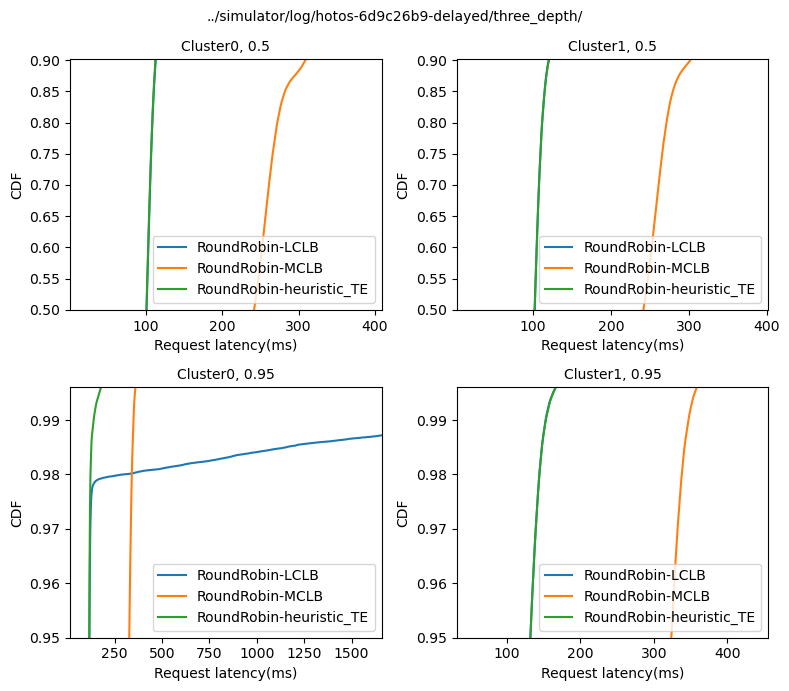

In [33]:
common_path="../simulator/log/hotos-6d9c26b9-delayed/three_depth/"
plot_latency(common_path)

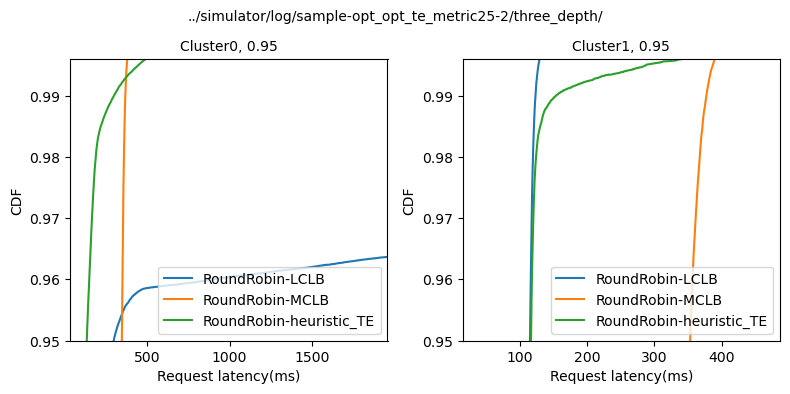

In [63]:
common_path="../simulator/log/sample-opt_opt_te_metric25-2/three_depth/"
plot_latency(common_path)

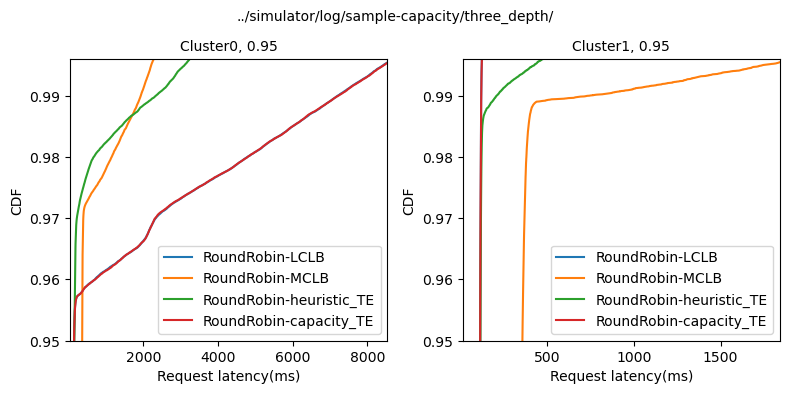

In [64]:
common_path="../simulator/log/sample-capacity/three_depth/"
plot_latency(common_path, ["RoundRobin-capacity_TE"])

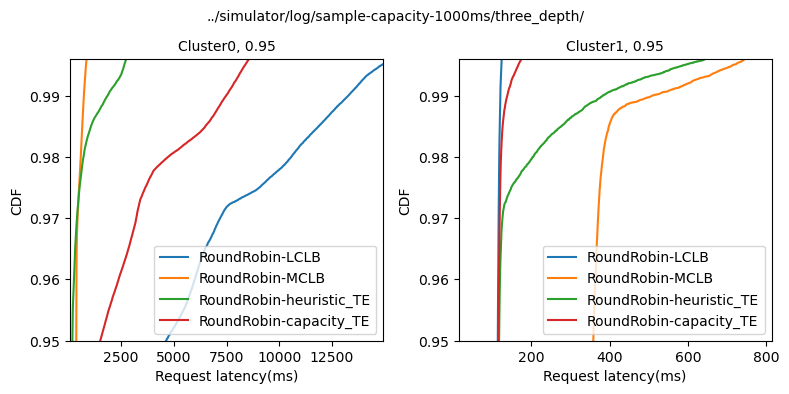

In [69]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-capacity_TE"])
# plot_latency(common_path)

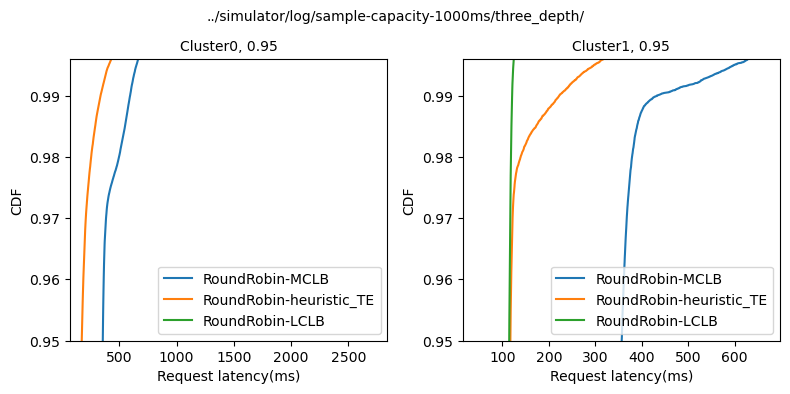

In [77]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE", "RoundRobin-LCLB", ]
)
# plot_latency(common_path)

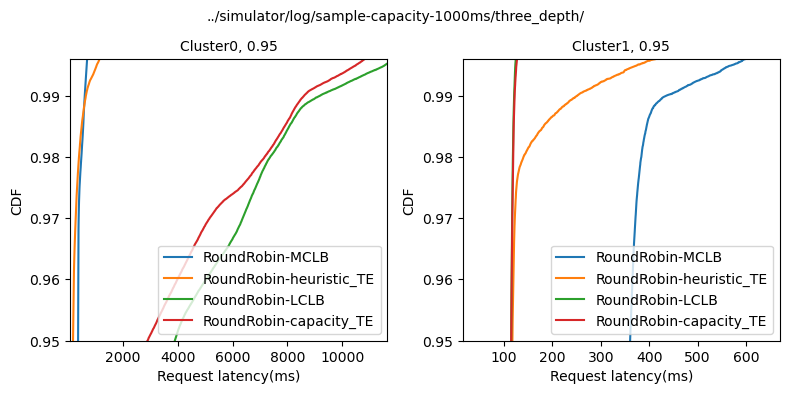

In [79]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE", "RoundRobin-LCLB", "RoundRobin-capacity_TE"])
# plot_latency(common_path)

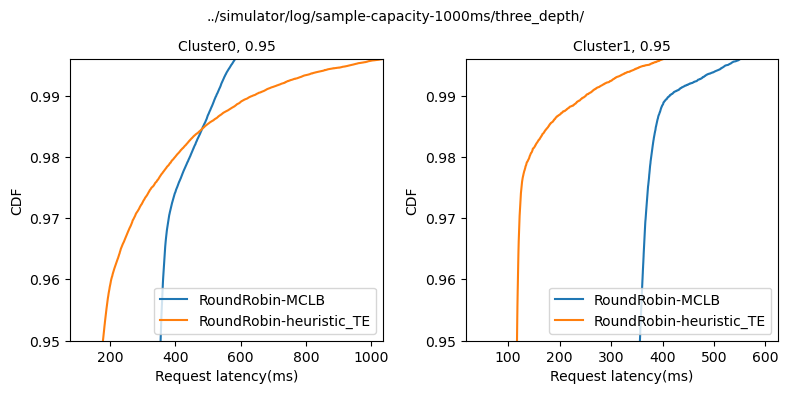

In [82]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE"])
# plot_latency(common_path)

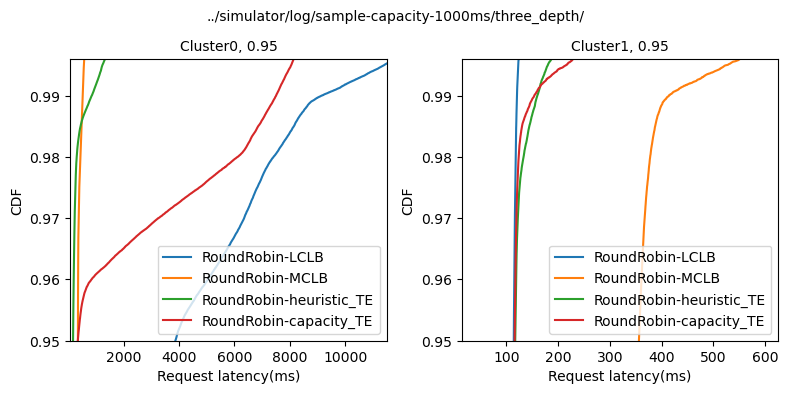

In [88]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
# plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE"])
plot_latency(common_path)

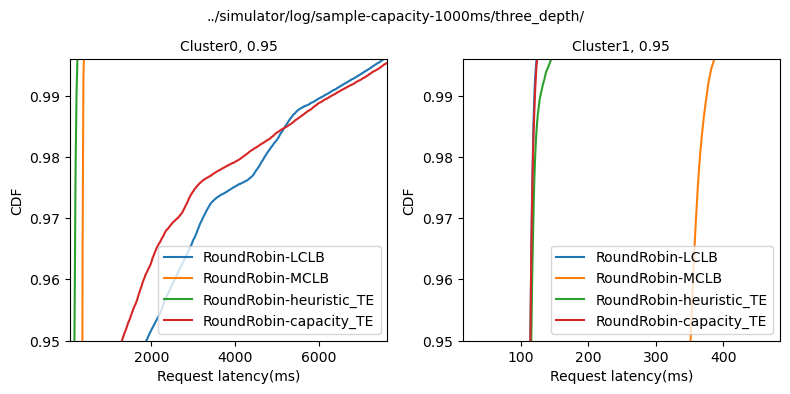

In [93]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
# plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE"])
plot_latency(common_path)

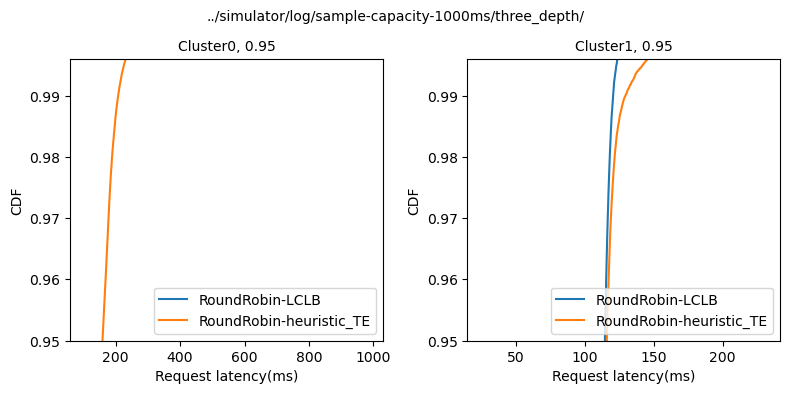

In [97]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-heuristic_TE"])
# plot_latency(common_path)

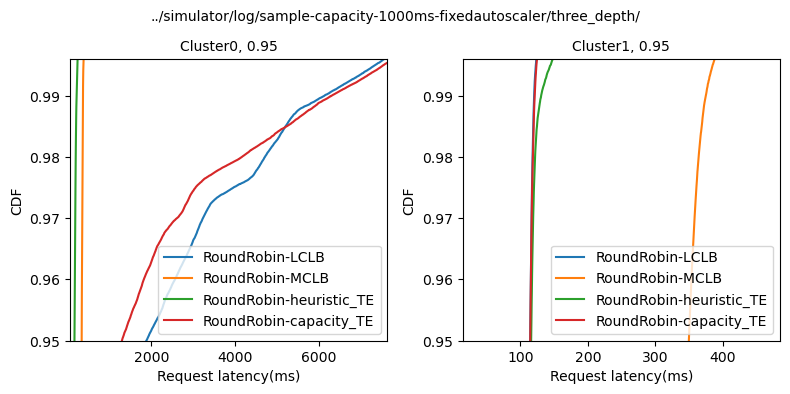

In [99]:
common_path="../simulator/log/sample-capacity-1000ms-fixedautoscaler/three_depth/"
# plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-heuristic_TE"])
plot_latency(common_path)

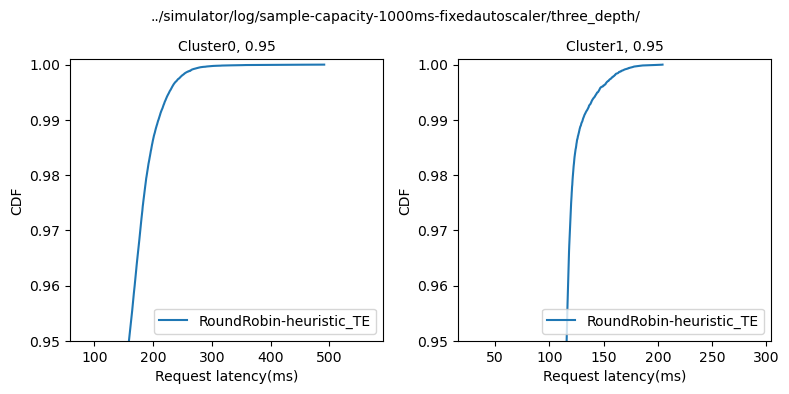

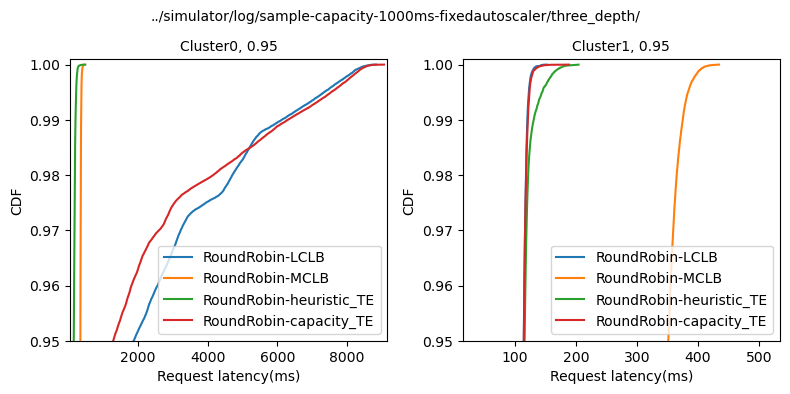

In [316]:
common_path="../simulator/log/sample-capacity-1000ms-fixedautoscaler/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE"])
plot_latency(common_path)

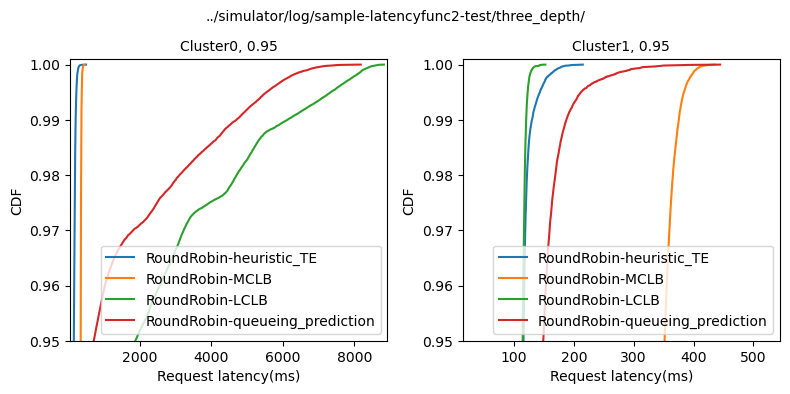

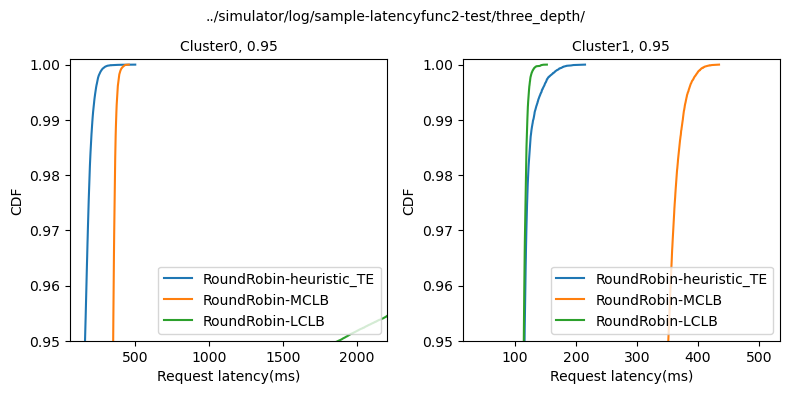

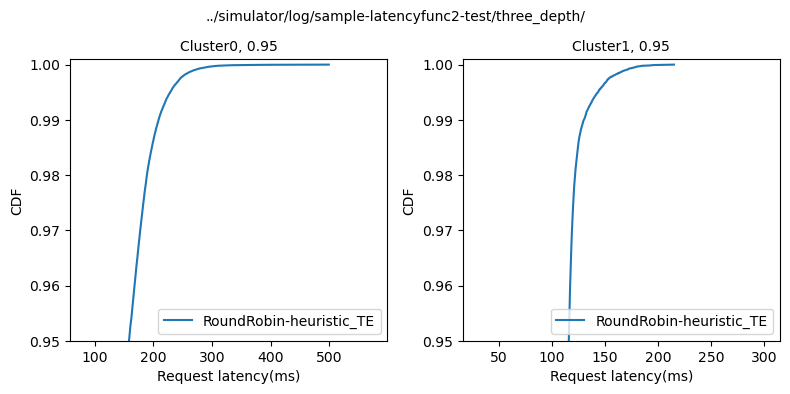

In [343]:
common_path="../simulator/log/sample-latencyfunc2-test/three_depth/"
# plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-capacity_TE", "RoundRobin-queueing_prediction"])
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB", "RoundRobin-queueing_prediction"])
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
plot_latency(common_path, ["RoundRobin-heuristic_TE"])
# plot_latency(common_path)

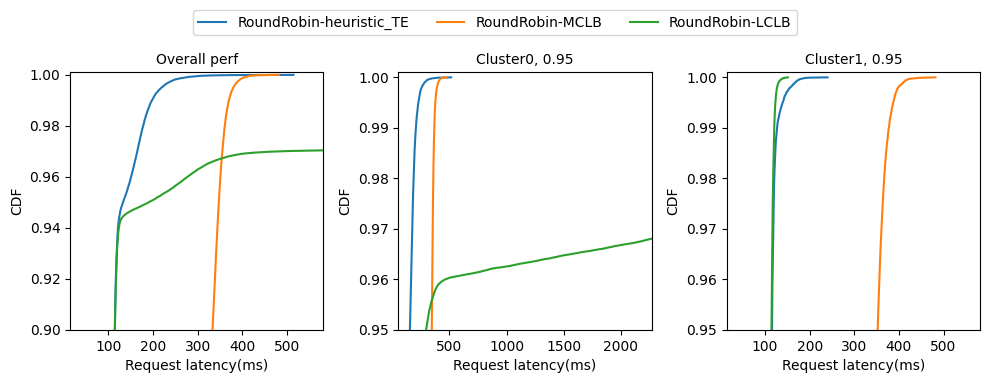

In [69]:
common_path="../simulator/log/sample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# plot_latency(common_path, ["LeastRequest-heuristic_TE", "LeastRequest-MCLB", "LeastRequest-LCLB"])

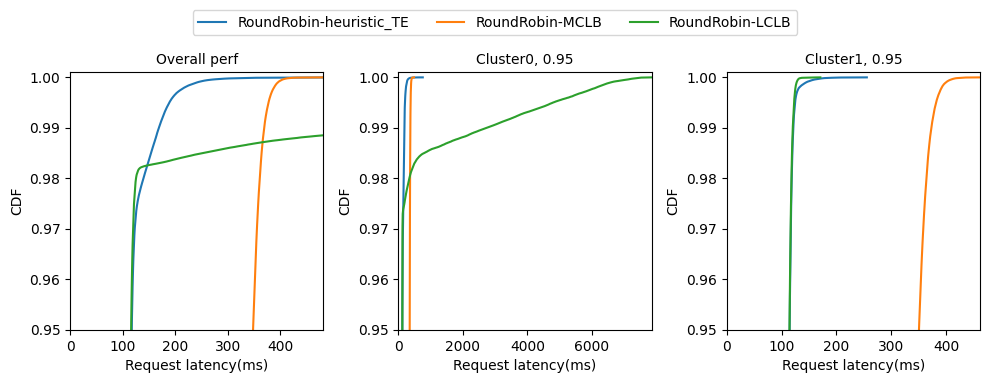

In [80]:
common_path="../simulator/log/halfsample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# 8s

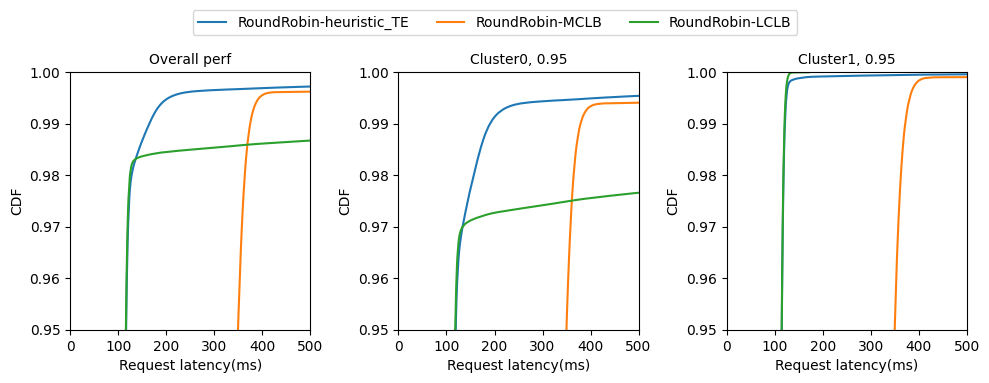

In [86]:
common_path="../simulator/log/fullsample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# 1m

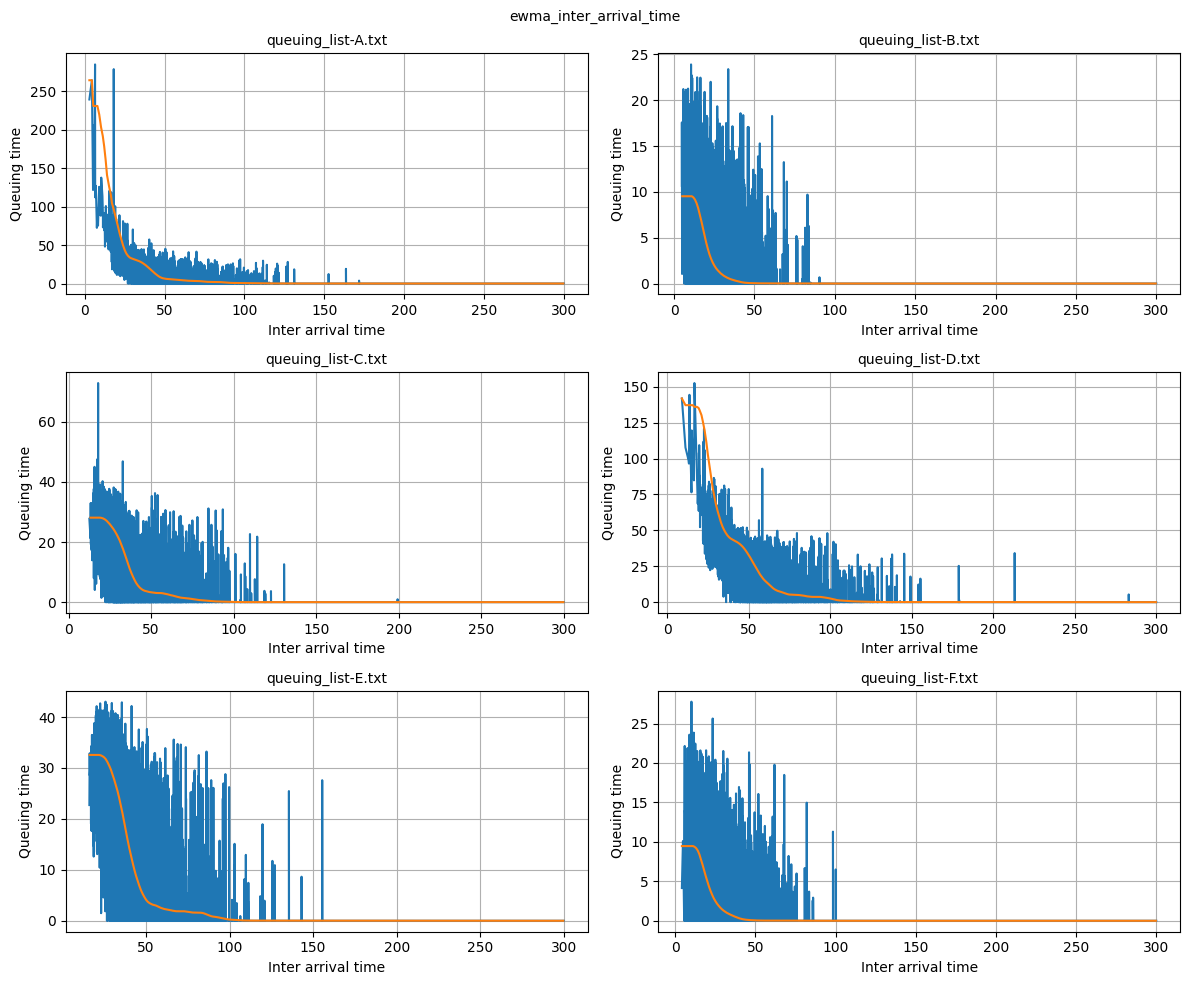

In [87]:
routing = "RoundRobin-heuristic_TE"
# routing = "RoundRobin-queueing_prediction"
common_path="../simulator/log/sample-latencyfunc2-test/three_depth/"
svc_list = ["A","B","C","D","E","F"]
inter_arrival_time_col =["moving_avg_inter_arrival_time_5"
                        ,"moving_avg_inter_arrival_time_10"
                        ,"moving_avg_inter_arrival_time_12"
                        ,"moving_avg_inter_arrival_time_15"
                        ,"moving_avg_inter_arrival_time_20"
                        ,"ewma_inter_arrival_time"]
inter_arrival_time_col =["ewma_inter_arrival_time"]

def latency_function_df(path_, target_inter_arr_time):
    df = pd.read_csv(path_)
    df["inverse_of_inter_arrival_time"] = 1/df[target_inter_arr_time]
    max_inter_arrival_time = 300
    num_drop = len(df[df[target_inter_arr_time] >= max_inter_arrival_time])
    df = df[df[target_inter_arr_time] < max_inter_arrival_time]
    df = df.sort_values(by=target_inter_arr_time)
    round_degree = 0
    df["rounded_inter_arrival_time"] = round(df[target_inter_arr_time], round_degree)
    # groupby_df = df.groupby('rounded_inter_arrival_time').max()
    # groupby_df = df.groupby('rounded_inter_arrival_time').min()
    groupby_df = df.groupby('rounded_inter_arrival_time').mean()
    groupby_df.reset_index(inplace=True)
    for i in range(len(groupby_df)):
        groupby_df.loc[i]
    df = df.reset_index(drop=False)
    # display(df)
    # display(groupby_df)
    return df, groupby_df


def ewma(curr, prev, lmda=0.632):
    # EWMA_t = λY_t+(1−λ)EWMA_t−1
    if prev == 0:
        return curr
    return lmda*curr + (1-lmda)*prev


# ## Original data point
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(common_path, fontsize=10)
# subplot_pos = 1
# for svc in svc_list:
#     pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
#     df, groupby_df = latency_function_df(pa_)
#     ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
#     plt.plot(df[inter_arrival_time_col], df["queuing_time"])
#     ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
#     ax1.set_ylabel("Queuing Time (Original)")#, fontsize=10)
#     ax1.set_title(pa_.split("/")[-1], fontsize=10)
#     subplot_pos += 1
# fig.tight_layout()
# plt.show()


# ## Moving average -> Round up by 0 degree ->  Mean Group by inter arrival time
# window_size = 5
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(common_path, fontsize=10)
# subplot_pos = 1
# for svc in svc_list:
#     pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
#     df, groupby_df = latency_function_df(pa_)
#     moving_avg_of_queuing_time = list()
#     temp_inter_arrival_time = list()
#     for i in range(window_size, len(groupby_df)):
#         moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
#         moving_avg_of_queuing_time.append(moving_avg)
#         temp_inter_arrival_time.append(groupby_df.loc[i, inter_arrival_time_col])
#     ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
#     plt.plot(temp_inter_arrival_time, moving_avg_of_queuing_time)
#     plt.grid()
#     ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
#     ax1.set_ylabel("Queuing Time (moving average)")#, fontsize=10)
#     # ax1.legend(loc="lower right", fontsize=10)
#     ax1.set_title(pa_.split("/")[-1], fontsize=10)
#     subplot_pos += 1
# fig.tight_layout()
# plt.show()


# ## Moving average -> Round up by 0 degree -> Mean Group by inter arrival time -> Monotonically increasing
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(common_path, fontsize=10)
# subplot_pos = 1
# for svc in svc_list:
#     pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
#     df, groupby_df = latency_function_df(pa_)
#     moving_avg_of_queuing_time = list()
#     temp_inter_arrival_time = list()
#     for i in range(window_size):
#         moving_avg_of_queuing_time.append(groupby_df.loc[i, "queuing_time"])
#         temp_inter_arrival_time.append(groupby_df.loc[i, inter_arrival_time_col])
#     for i in range(window_size, len(groupby_df)):
#         moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
#         moving_avg_of_queuing_time.append(moving_avg)
#         temp_inter_arrival_time.append(groupby_df.loc[i, inter_arrival_time_col])
#     monotonic_function = list()
#     prev_max = 0
#     for elem in reversed(moving_avg_of_queuing_time):
#         prev_max = max(prev_max, elem)
#         monotonic_function.append(prev_max)
#     monotonic_function.reverse()
#     ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
#     # plt.plot(temp_inter_arrival_time, moving_avg_of_queuing_time)
#     plt.plot(temp_inter_arrival_time, monotonic_function)
#     plt.grid()
#     # plt.plot(df[inter_arrival_time_col], df["queuing_time"])
#     # ax1.tick_params(axis='y', labelsize=10)
#     # ax1.tick_params(axis='x', labelsize=10)
#     ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
#     ax1.set_ylabel("Queuing Time (monotonic)")#, fontsize=10)
#     # ax1.legend(loc="lower right", fontsize=10)
#     ax1.set_title(pa_.split("/")[-1], fontsize=10)
#     subplot_pos += 1
# fig.tight_layout()
# plt.show()



## Moving average -> Round up by 0 degree -> Max Group by inter arrival time -> Monotonically increasing -> Moving average -> Monotonically increasing
for int_arr_t in inter_arrival_time_col:
    window_size = 5
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(int_arr_t, fontsize=10)
    subplot_pos = 1
    for svc in svc_list:
        pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
        df, groupby_df = latency_function_df(pa_, int_arr_t)
        moving_avg_of_queuing_time = list()
        temp_inter_arrival_time = list()
        for i in range(window_size):
            moving_avg_of_queuing_time.append(groupby_df.loc[i, "queuing_time"])
            temp_inter_arrival_time.append(groupby_df.loc[i, int_arr_t])
        for i in range(window_size, len(groupby_df)):
            moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
            moving_avg_of_queuing_time.append(moving_avg)
            temp_inter_arrival_time.append(groupby_df.loc[i, int_arr_t])
        monotonic_function = list()
        prev_max = 0
        for elem in reversed(moving_avg_of_queuing_time):
            prev_max = max(prev_max, elem)
            monotonic_function.append(prev_max)
        monotonic_function.reverse()
        ###########################################################################
        moving_avg_monotonic_function = list()
        temp_inter_arrival_time2 = list()
        for i in range(window_size):
            moving_avg_monotonic_function.append(monotonic_function[i])
            temp_inter_arrival_time2.append(temp_inter_arrival_time[i])
        for i in range(window_size, len(monotonic_function)):
            moving_avg = sum(monotonic_function[i-window_size:i])/window_size
            moving_avg_monotonic_function.append(moving_avg)
            temp_inter_arrival_time2.append(temp_inter_arrival_time[i])
        prev_max = 0
        moving_avg_mono_mono = list()
        for elem in reversed(moving_avg_monotonic_function):
            prev_max = max(elem, prev_max)
            moving_avg_mono_mono.append(prev_max)
        moving_avg_mono_mono.reverse()
        # path_ = common_path + routing + "/"+int_arr_t+"_queuing_function-"+svc+".txt"
        # with open(path_, "w") as f_:
        #     for i in range(len(moving_avg_mono_mono)):
        #         f_.write(str(temp_inter_arrival_time2[i]) +","+ str(moving_avg_mono_mono[i])+"\n")
        ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
        plt.plot(df[int_arr_t], df["queuing_time"])
        plt.plot(temp_inter_arrival_time2, moving_avg_mono_mono)
        plt.grid()
        ax1.set_xlabel("Inter arrival time")#, fontsize=10)
        ax1.set_ylabel("Queuing time")#, fontsize=10)
        ax1.set_title(pa_.split("/")[-1], fontsize=10)
        subplot_pos += 1
    fig.tight_layout()
    plt.show()
    plt.close()
    

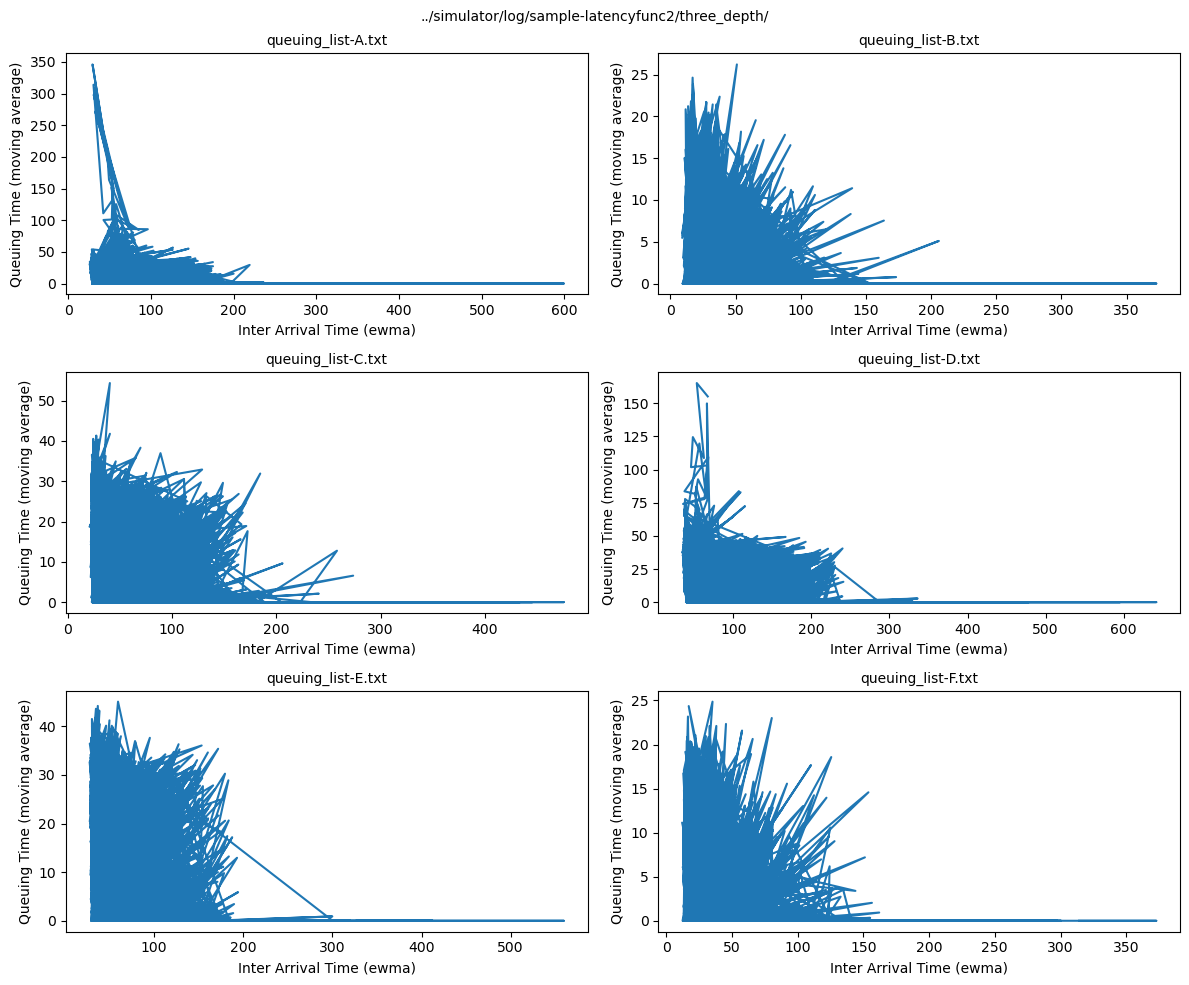

In [265]:
routing = "RoundRobin-heuristic_TE"
# routing = "RoundRobin-LCLB"
# routing = "RoundRobin-MCLB"
common_path="../simulator/log/sample-latencyfunc2/three_depth/"
svc_list = ["A","B","C","D","E","F"]
# svc_list = ["A"]
window_size = 5
fig = plt.figure(figsize=(12, 10))
fig.suptitle(common_path, fontsize=10)
subplot_pos = 1
for svc in svc_list:
    pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
    df, groupby_df = latency_function_df(pa_)
    moving_avg_of_queuing_time = list()
    temp_inter_arrival_time = list()
    for i in range(window_size, len(groupby_df)):
        moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
        moving_avg_of_queuing_time.append(moving_avg)
        temp_inter_arrival_time.append(groupby_df.loc[i, "ewma_inter_arrival_time"])
    ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
    # plt.plot(temp_inter_arrival_time, moving_avg_of_queuing_time)
    plt.plot(df["moving_avg_inter_arrival_time"], df["queuing_time"])
    ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
    ax1.set_ylabel("Queuing Time (moving average)")#, fontsize=10)
    # ax1.legend(loc="lower right", fontsize=10)
    ax1.set_title(pa_.split("/")[-1], fontsize=10)
    subplot_pos += 1
fig.tight_layout()
plt.show()
